<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the good stuff
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## A few utility functions

In [2]:
# from model import VeryTinyNerfModel
from image_encoder import ImageEncoder
from data_utils import load_tiny_nerf_data, load_nerf_data, get_focal_length
from nerf_utils import positional_encoding, get_minibatches, run_one_iter_of_tinynerf
from utils import select_frames_from_baseline, select_frames_from_clustering, calculate_lpips, calculate_ssim

In [3]:
# experiment_data_type = "tiny_nerf"
# experiment_data_type = "nerf_synthetic"
# nerf_test_subject = "ship" if experiment_data_type == "nerf_synthetic" else "lego" 
# nerf_subjects_list = ['ship', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic']

tiny_data_path = "data/tiny_nerf_data.npz"
nerf_synthetic_path = "data/nerf_synthetic"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if experiment_data_type == "tiny_nerf":
#     logs_path = f"logs/{experiment_data_type}"
# else:
#     logs_path = f"logs/{experiment_data_type}/{nerf_test_subject}"

## Get data

In [8]:
# Download sample data used in the official tiny_nerf example
if not os.path.exists(tiny_data_path):
    !wget -P data/ http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [9]:
# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Height and width of each image
height, width = 100, 100

# if experiment_data_type == "tiny_nerf":
#     images, tform_cam2world, focal_length, testimgs, testposes = load_tiny_nerf_data(tiny_data_path, device)
# else:
#     images, train_poses, camera_angle_x = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_train.json')
#     tform_cam2world = train_poses

#     focal_length = get_focal_length(width, camera_angle_x)
#     focal_length = torch.from_numpy(focal_length).to(device)

#     # Hold one image out (for test).
#     testimgs, testposes, _ = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_test.json', skip_images=20)

#     testimgs = testimgs.to(device)
#     testposes = torch.from_numpy(testposes).to(device)

#     # # Map images to device
#     images = images.to(device)
#     tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

In [22]:
experiment_data_type = {
    #"nerf_synthetic": ['ship', 'drums', 'ficus', 'hotdog', 'materials', 'mic'],
    "nerf_synthetic": ['ship', 'drums', 'ficus', 'hotdog', 'materials', 'chair'],
    "tiny_nerf": 'lego'}

## Plot 1

In [23]:
def plot_clusters(images, nerf_subject, stats_file):
    # Extract embeddings from the images
    image_encoder = ImageEncoder().to(device)
    embeddings = image_encoder(images)
     
    # Read the data from the stats file
    with open(stats_file, 'r') as file:
        data = file.readlines()

    # Extract the UMAP params from the stats file
    umap_params = []
    hdbscan_params = []

    for line in data:
        if 'n_neighbors' in line:
            umap_params.append(int(line.split(':')[-1].strip()))
        elif 'min_dist' in line:
            umap_params.append(float(line.split(':')[-1].strip()))
        elif 'n_components' in line:
            umap_params.append(int(line.split(':')[-1].strip()))
        elif 'min_cluster_size' in line:
            hdbscan_params.append(int(line.split(':')[-1].strip()))
        elif 'min_samples' in line:
            hdbscan_params.append(int(line.split(':')[-1].strip()))

    scaled_embeddings = extract_features(embeddings, dim_red_method = "umap", umap_params = umap_params)
    labels = HDBSCAN(min_cluster_size=hdbscan_params[0], min_samples=hdbscan_params[1]).fit_predict(embeddings)

    # Assuming embeddings is a numpy array of shape (n_samples, 5)
    # Assuming labels are the cluster labels obtained from HDBSCAN

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each point with a different color based on its cluster label
    for label in set(labels):
        if label == -1:
            continue  # Skip noise points

        indices = labels == label
        cluster_points = embeddings[indices]

        ax.scatter(
            cluster_points[:, 0],  # Dimension 1
            cluster_points[:, 1],  # Dimension 2
            cluster_points[:, 2],  # Dimension 3
            label=f'Cluster {label}',
            alpha=0.8
        )

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title(f'Clusters Visualization for {nerf_subject}')
    ax.legend()
    plt.show() 

# Plot 3

In [24]:
def plot_psnr_lpips_ssim(logs_path):
    psnr_vals_dict = {}
    lpips_vals_dict = {}
    ssim_vals_dict = {}

    # Read the data from the npy file
    psnr_data1 = np.load(f"{logs_path}/results/psnr_vals_dict_baseline.npy", allow_pickle=True).item()
    psnr_data2 = np.load(f"{logs_path}/results/psnr_vals_dict_clustering.npy", allow_pickle=True).item()
    lpips_data1 = np.load(f"{logs_path}/results/lpips_vals_dict_baseline.npy", allow_pickle=True).item()
    lpips_data2 = np.load(f"{logs_path}/results/lpips_vals_dict_clustering.npy", allow_pickle=True).item()
    ssim_data1 = np.load(f"{logs_path}/results/ssim_vals_dict_baseline.npy", allow_pickle=True).item()
    ssim_data2 = np.load(f"{logs_path}/results/ssim_vals_dict_clustering.npy", allow_pickle=True).item()

    for strategy, values in psnr_data1.items():
        psnr_vals_dict[strategy] = values

    for strategy, values in psnr_data2.items():
        psnr_vals_dict["embedding"] = values

    for strategy, values in lpips_data1.items():
        lpips_vals_dict[strategy] = values
    
    for strategy, values in lpips_data2.items():
        lpips_vals_dict["embedding"] = values

    for strategy, values in ssim_data1.items():
        ssim_vals_dict[strategy] = values

    for strategy, values in ssim_data2.items():
        ssim_vals_dict["embedding"] = values
    
    # Plot PSNR, SSIM, and LPIPS in subplots
    plt.figure(figsize=(15, 4))

    plt.subplot(131)
    for strategy, values in psnr_vals_dict.items():
        plt.plot(values, label="PSNR for " + strategy + ": {:.4f}".format(values[-1]))
    plt.legend()
    plt.title("PSNR)

    plt.subplot(132)
    for strategy, values in lpips_vals_dict.items():
        plt.plot(values, label="LPIPS for " + strategy + ": {:.4f}".format(values[-1]))
    plt.legend()
    plt.title("LPIPS")

    plt.subplot(133)
    for strategy, values in ssim_vals_dict.items():
        plt.plot(values, label="SSIM for " + strategy + ": {:.4f}".format(values[-1]))
    plt.legend()
    plt.title("SSIM")

    plt.tight_layout()

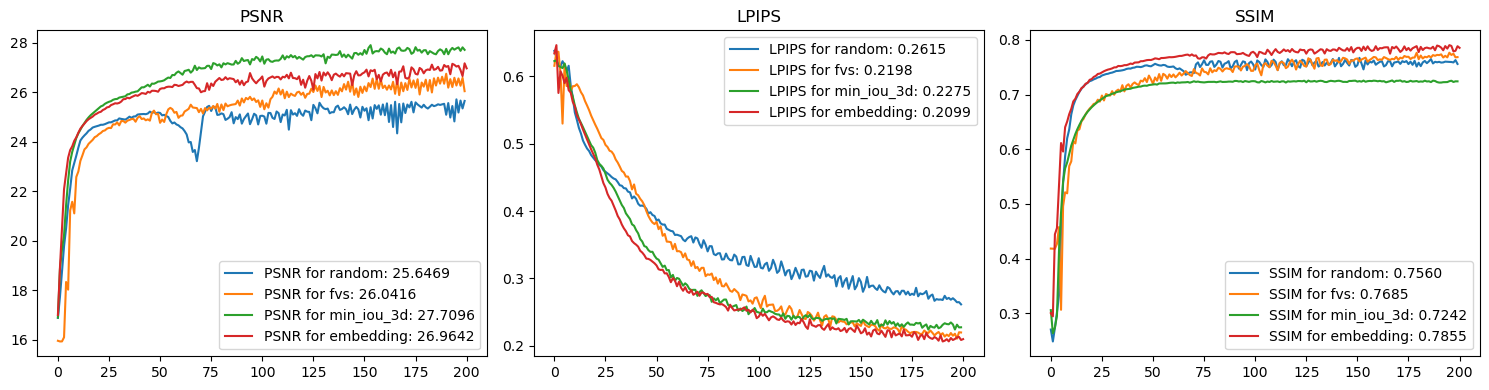

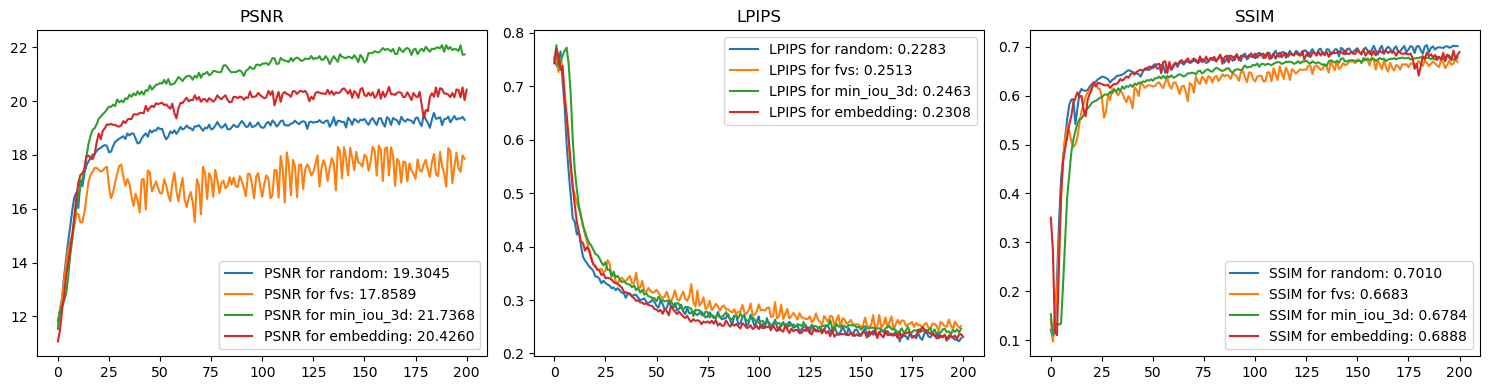

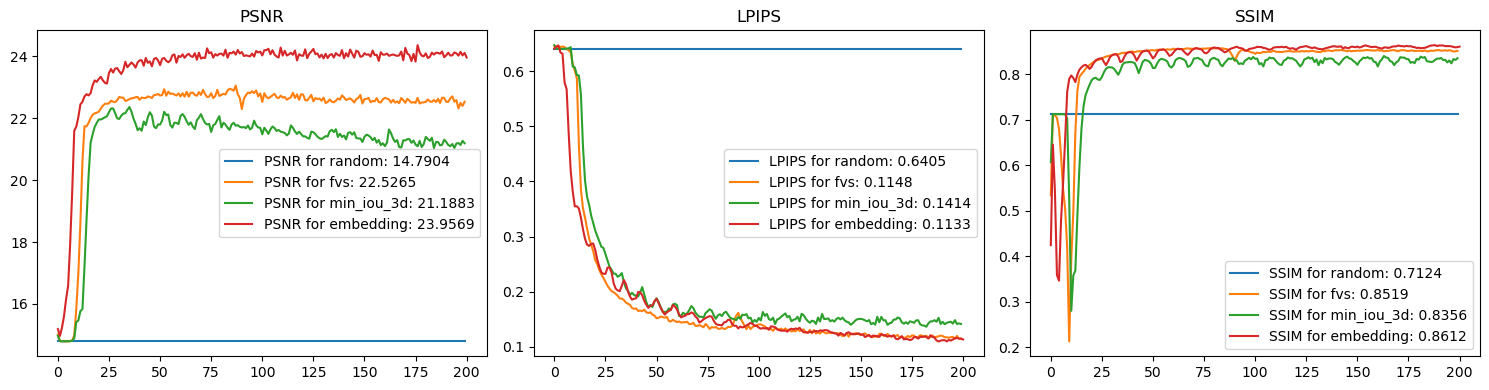

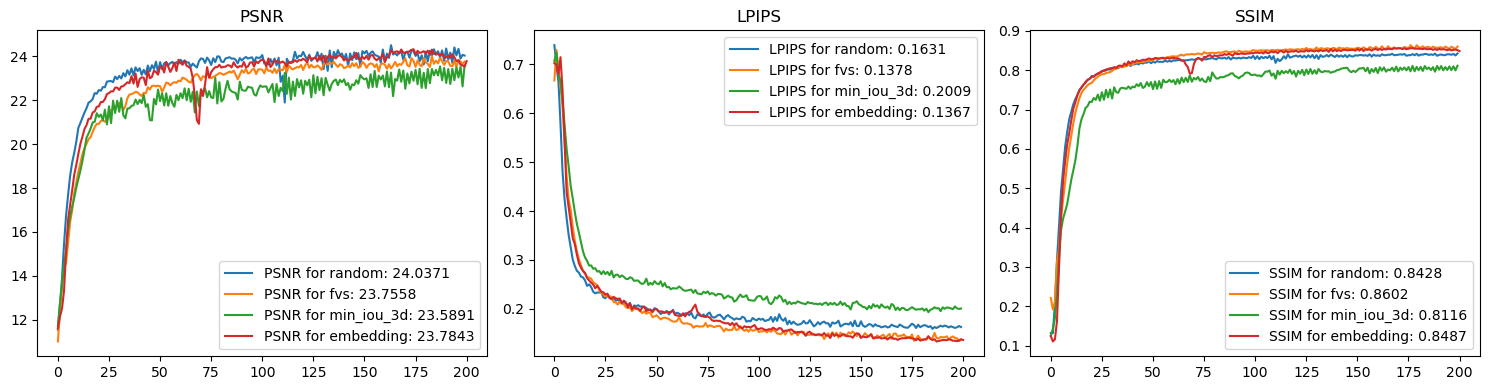

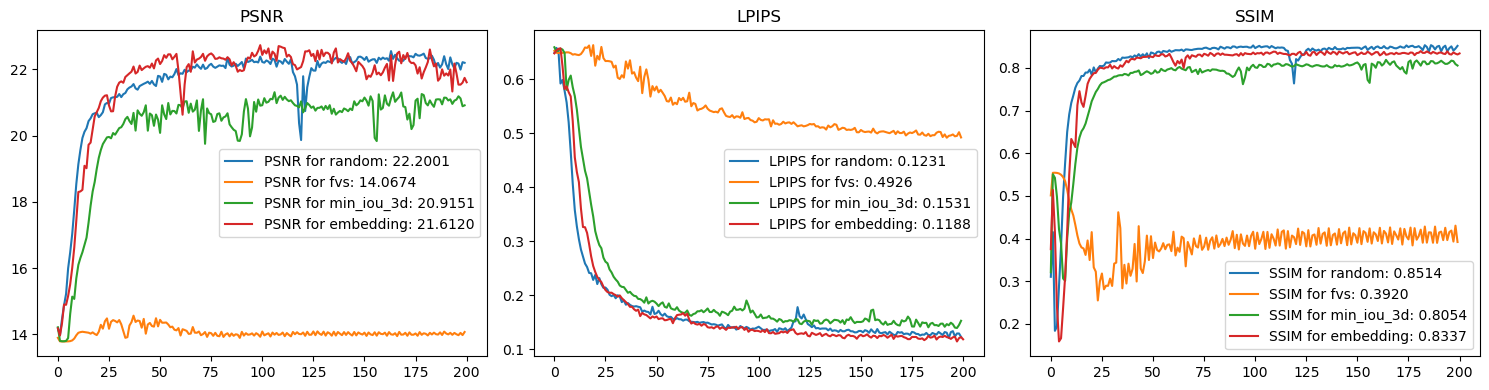

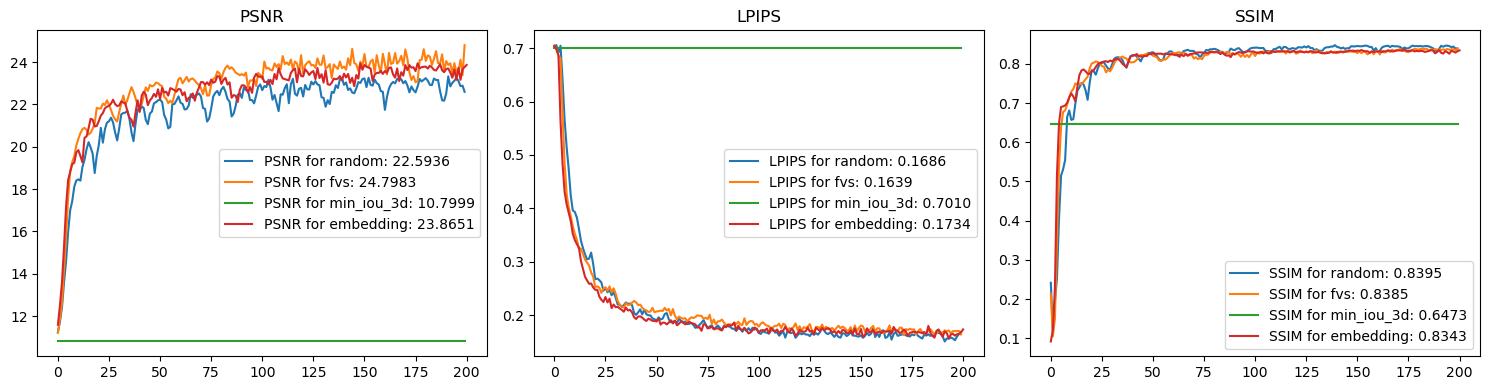

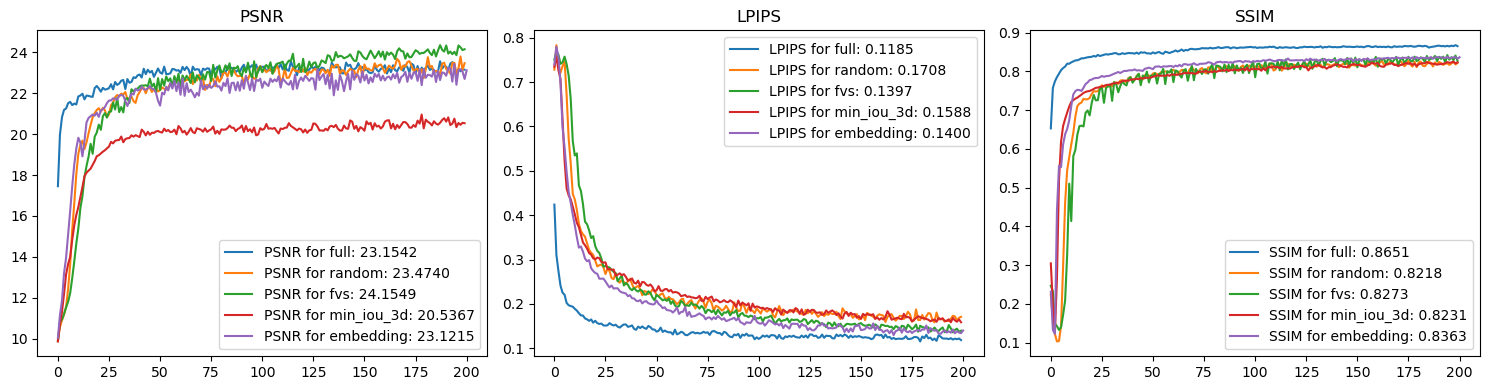

In [25]:
logs_path = f"logs/"
stats_file = ""

for key, values in experiment_data_type.items():
    logs_path = f"logs/{key}"
    if key == "tiny_nerf":
        stats_file = os.path.join(logs_path, "optuna_stats.txt")

        images, tform_cam2world, focal_length, testimgs, testposes = load_tiny_nerf_data(tiny_data_path, device)

        # plot1
        # plot_clusters(images, key, stats_file)

        # plot2
        # plot_method_clusters(images, key, stats_file)
        
        # plot3
        plot_psnr_lpips_ssim(logs_path)
    else:
        for nerf_subject in values:
            stats_file = os.path.join(logs_path, nerf_subject, "optuna_stats.txt")
            logs_path = f"logs/{key}/{nerf_subject}"
            
            images, train_poses, camera_angle_x = load_nerf_data(nerf_synthetic_path, nerf_subject, 'transforms_train.json')
            tform_cam2world = train_poses

            focal_length = get_focal_length(width, camera_angle_x)
            focal_length = torch.from_numpy(focal_length).to(device)

            # Hold one image out (for test).
            testimgs, testposes, _ = load_nerf_data(nerf_synthetic_path, nerf_subject, 'transforms_test.json', skip_images=20)

            testimgs = testimgs.to(device)
            testposes = torch.from_numpy(testposes).to(device)

            # Map images to device
            images = images.to(device)
            tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)
            
            # plot1
            # plot_clusters(images, nerf_subject, stats_file)

            # plot2
            # plot_method_clusters(images, nerf_subject, stats_file)
            
            # plot3
            plot_psnr_lpips_ssim(logs_path)